In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# LOAD DATA
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("flight_delay_modeling_data.csv")
df.head()


Saving flight_delay_modeling_data.csv to flight_delay_modeling_data (1).csv


,Month,DayOfWeek,IsWeekend,Season,Year,DepTime,CRSDepTime,CRSArrTime,Distance,Reporting_Airline,...,OriginLowVisibility,DestLowVisibility,origin_temp_c,dest_temp_c,origin_visibility_m,dest_visibility_m,Route,ArrDelay,ArrDel15,ArrDel30
0,1,1,0,1,2018,37.0,45,702,2075.0,AA,...,0,0,16.1,-12.2,16093.0,16093.0,PHX-PHL,-12.0,0.0,0
1,1,1,0,1,2018,557.0,600,804,666.0,AA,...,0,0,-3.3,-12.8,16000.0,16093.0,ATL-PHL,-27.0,0.0,0
2,1,1,0,1,2018,818.0,830,959,335.0,OH,...,0,0,-17.2,-12.8,16093.0,16093.0,CAK-PHL,1.0,0.0,0
3,1,1,0,1,2018,720.0,700,1017,814.0,YX,...,0,0,-18.3,-12.8,16093.0,16093.0,STL-PHL,14.0,0.0,0
4,1,1,0,1,2018,846.0,848,1026,280.0,B6,...,0,0,-17.2,-12.8,16000.0,16093.0,BOS-PHL,-19.0,0.0,0


In [31]:
# Drop leakage columns if present
leak_cols = ["ArrDelay", "ArrDel30"]  # adjust based on dataset
df = df.drop(columns=[col for col in leak_cols if col in df.columns])

# Define target
target = "ArrDel15"
y = df[target]
X = df.drop(columns=[target])

# ---- DROP DepTime HERE ----
if "DepTime" in X.columns:
    X = X.drop(columns=["DepTime"])
# ----------------------------

X.head()


,Month,DayOfWeek,IsWeekend,Season,Year,CRSDepTime,CRSArrTime,Distance,Reporting_Airline,Origin,Dest,OriginLowVisibility,DestLowVisibility,origin_temp_c,dest_temp_c,origin_visibility_m,dest_visibility_m,Route
0,1,1,0,1,2018,45,702,2075.0,AA,PHX,PHL,0,0,16.1,-12.2,16093.0,16093.0,PHX-PHL
1,1,1,0,1,2018,600,804,666.0,AA,ATL,PHL,0,0,-3.3,-12.8,16000.0,16093.0,ATL-PHL
2,1,1,0,1,2018,830,959,335.0,OH,CAK,PHL,0,0,-17.2,-12.8,16093.0,16093.0,CAK-PHL
3,1,1,0,1,2018,700,1017,814.0,YX,STL,PHL,0,0,-18.3,-12.8,16093.0,16093.0,STL-PHL
4,1,1,0,1,2018,848,1026,280.0,B6,BOS,PHL,0,0,-17.2,-12.8,16000.0,16093.0,BOS-PHL


In [32]:
# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Convert to category dtype (LightGBM-friendly)
for col in cat_cols:
    X[col] = X[col].astype('category')

cat_cols


['Reporting_Airline', 'Origin', 'Dest', 'Route']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [34]:
import lightgbm as lgb

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_cols
)

test_data = lgb.Dataset(
    X_test,
    label=y_test,
    categorical_feature=cat_cols
)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=200
)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 321530, number of negative: 1408896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7071
[LightGBM] [Info] Number of data points in the train set: 1730426, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.185810 -> initscore=-1.477471
[LightGBM] [Info] Start training from score -1.477471


In [35]:
# Predict probabilities and labels
pred_prob = model.predict(X_test)
pred = (pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1 Score:", f1_score(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, pred_prob))


Accuracy: 0.8163298328506011
Precision: 0.5647190383002516
Recall: 0.05025938320291604
F1 Score: 0.0923038258108
ROC-AUC: 0.6942413155566829


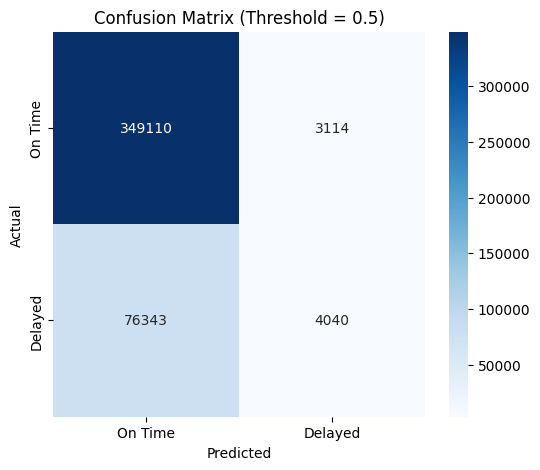

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["On Time", "Delayed"],
            yticklabels=["On Time", "Delayed"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()

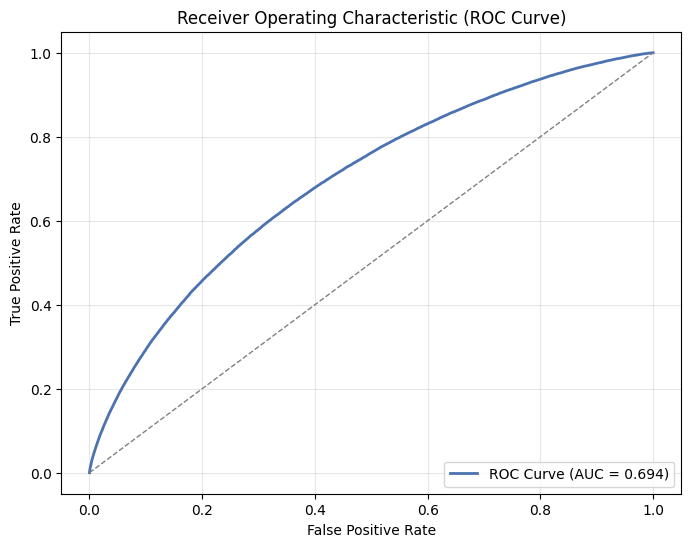

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='#4C72B0', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC Curve)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

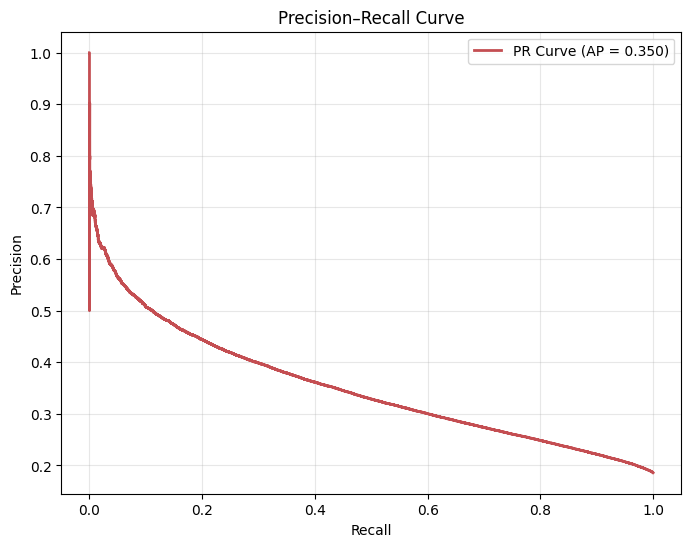

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, pr_thresh = precision_recall_curve(y_test, pred_prob)
avg_precision = average_precision_score(y_test, pred_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='#C44E52', lw=2, label=f'PR Curve (AP = {avg_precision:.3f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()

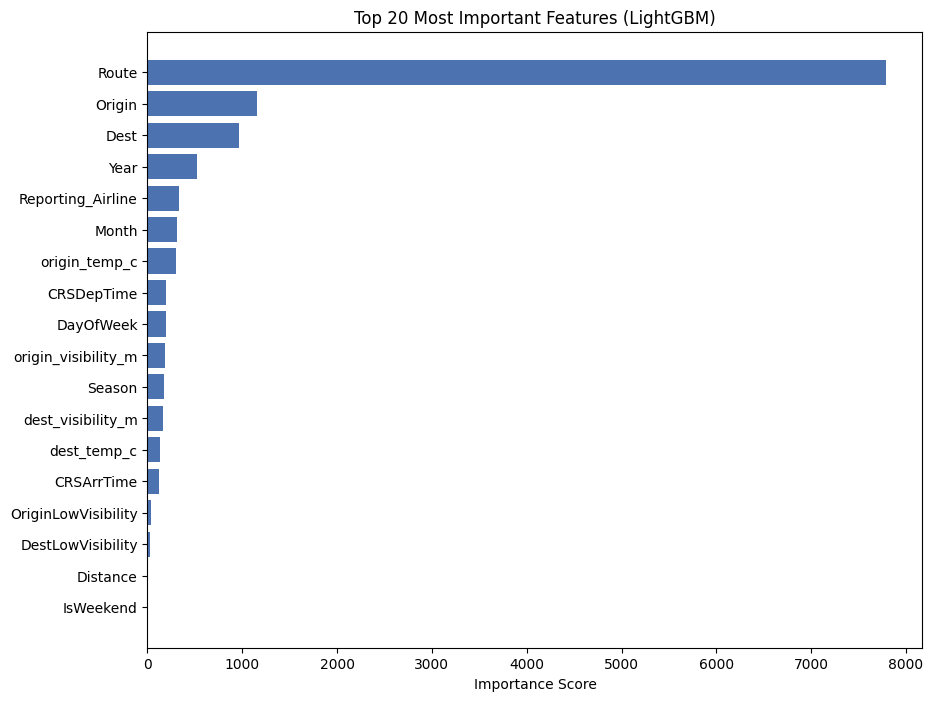

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importance
importance = model.feature_importance()
feature_names = X.columns

# Sort by importance
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 8))
plt.barh([feature_names[i] for i in indices[:20]][::-1], importance[indices[:20]][::-1], color="#4C72B0")
plt.xlabel("Importance Score")
plt.title("Top 20 Most Important Features (LightGBM)")
plt.show()




In [23]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    eval_metric='AUC',
    loss_function='Logloss',
    random_seed=42,
    verbose=50
)

cat_model.fit(
    X, y,
    cat_features=cat_cols,   # <--- AUTOMATICALLY handles categories
)


0:	total: 4.17s	remaining: 20m 48s
50:	total: 2m 53s	remaining: 14m 9s


In [42]:
cat_pred_prob = cat_model.predict_proba(X_test)[:, 1]
cat_pred = (cat_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, cat_pred))
print("Precision:", precision_score(y_test, cat_pred))
print("Recall:", recall_score(y_test, cat_pred))
print("F1 Score:", f1_score(y_test, cat_pred))
print("ROC-AUC:", roc_auc_score(y_test, cat_pred_prob))


Accuracy: 0.8169146592634886
Precision: 0.6207249641613762
Recall: 0.03770697784357389
F1 Score: 0.07109516102549668
ROC-AUC: 0.7022411320413824


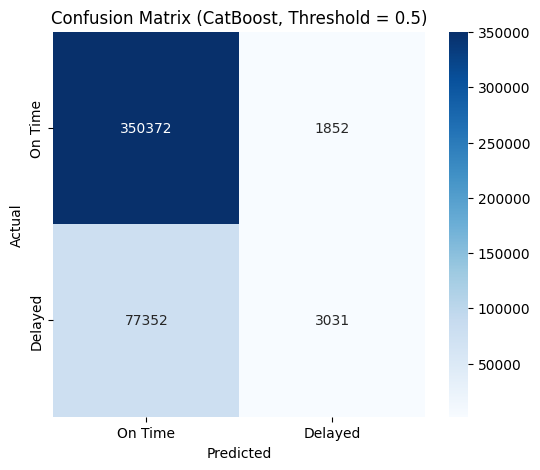

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, cat_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=["On Time", "Delayed"],
    yticklabels=["On Time", "Delayed"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (CatBoost, Threshold = 0.5)")
plt.show()


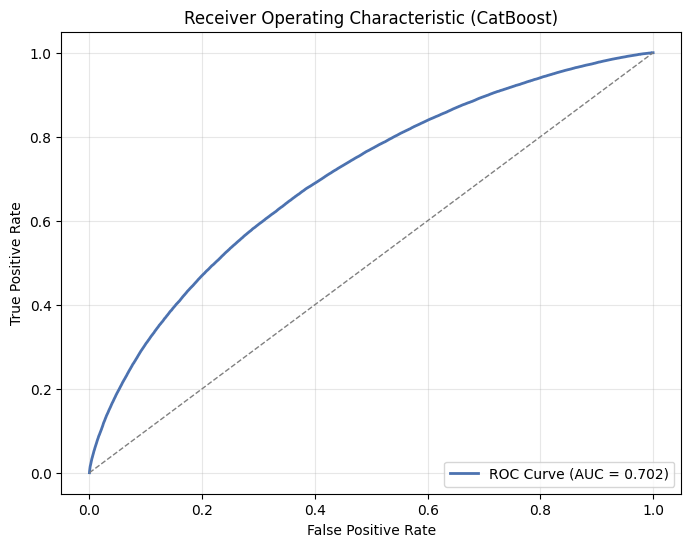

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, cat_pred_prob)
roc_auc = roc_auc_score(y_test, cat_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#4C72B0', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (CatBoost)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


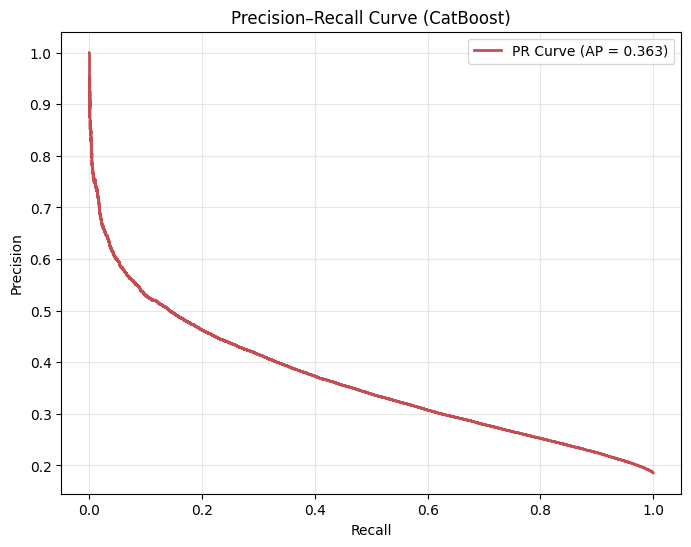

In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, cat_pred_prob)
avg_precision = average_precision_score(y_test, cat_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#C44E52', lw=2,
         label=f"PR Curve (AP = {avg_precision:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (CatBoost)")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()


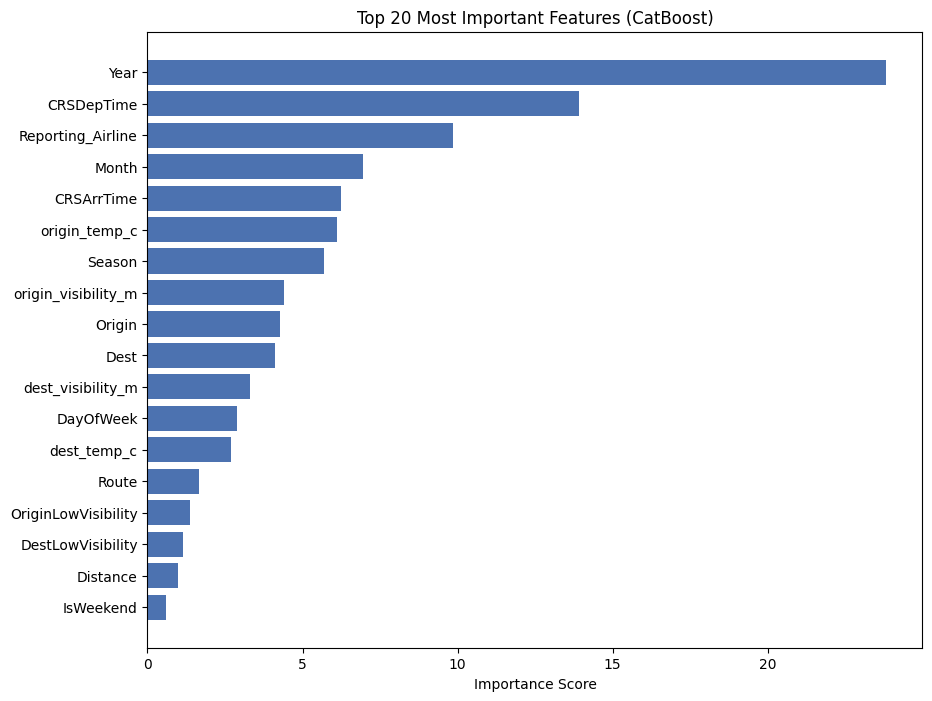

In [47]:
import numpy as np
import matplotlib.pyplot as plt

feature_importance = cat_model.get_feature_importance()
feature_names = X.columns

idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 8))
plt.barh(
    [feature_names[i] for i in idx[:20]][::-1],
    feature_importance[idx[:20]][::-1],
    color='#4C72B0'
)

plt.xlabel("Importance Score")
plt.title("Top 20 Most Important Features (CatBoost)")
plt.show()


Dropping: ['DepTime']
Scale Pos Weight: 4.3818492831151055

DEFAULT THRESHOLD (0.5)
Accuracy: 0.662536667229148
Precision: 0.2971893509416231
Recall: 0.597987136583606
F1 Score: 0.3970511099638616

SEARCHING FOR BEST THRESHOLD:
t=0.05 | F1=0.314
t=0.10 | F1=0.316
t=0.15 | F1=0.321
t=0.20 | F1=0.330
t=0.25 | F1=0.341
t=0.30 | F1=0.353
t=0.35 | F1=0.367
t=0.40 | F1=0.381
t=0.45 | F1=0.392
t=0.50 | F1=0.397
t=0.55 | F1=0.394
t=0.60 | F1=0.377
t=0.65 | F1=0.339
t=0.70 | F1=0.277
t=0.75 | F1=0.191
t=0.80 | F1=0.096
t=0.85 | F1=0.026
t=0.90 | F1=0.003

BEST THRESHOLD = 0.5 F1 = 0.3970511099638616

METRICS WITH OPTIMAL THRESHOLD
Accuracy: 0.662536667229148
Precision: 0.2971893509416231
Recall: 0.597987136583606
F1: 0.3970511099638616
ROC-AUC: 0.6901014431744423


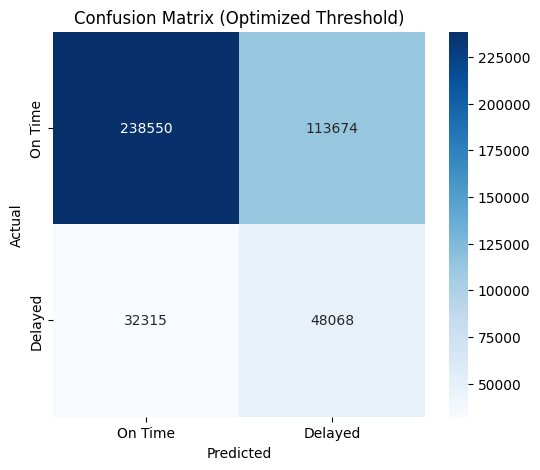

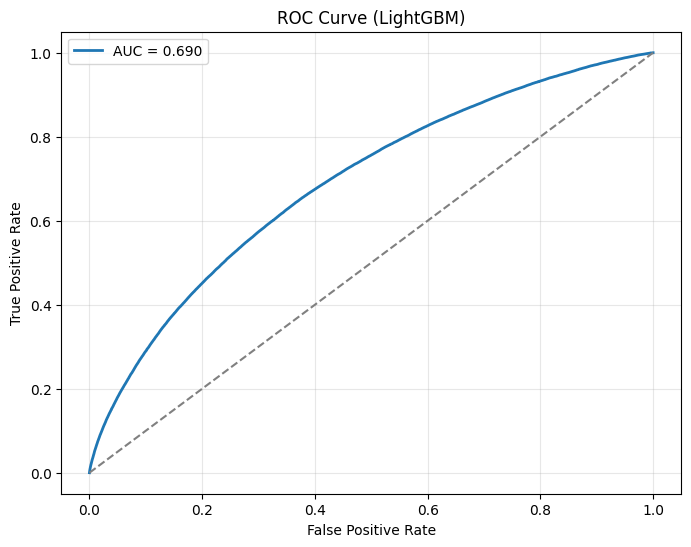

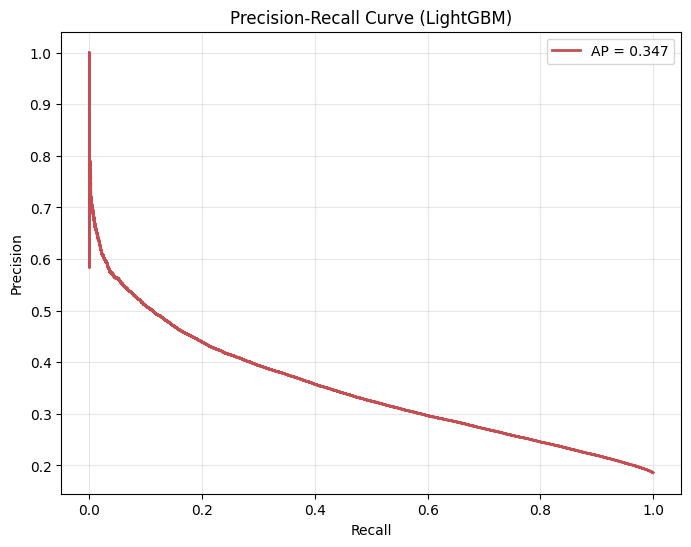

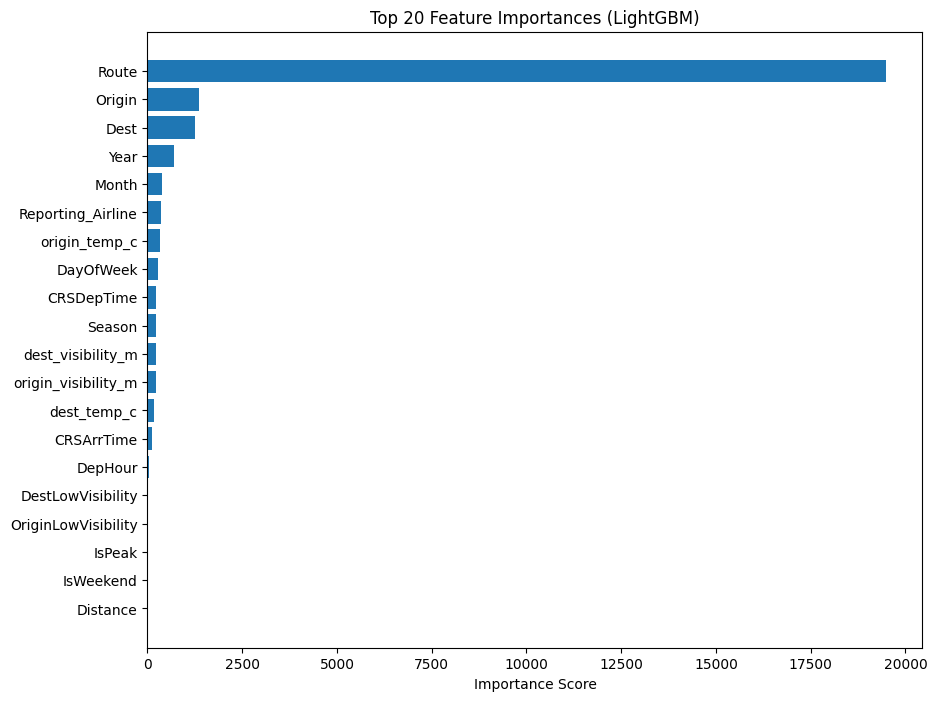

In [53]:
# ==========================================
# IMPROVED LIGHTGBM MODEL BLOCK (DROP-IN)
# ==========================================

import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, average_precision_score
)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------
# 1. ADD BETTER FEATURES (no cheating)
# --------------------------------------------------
df["DepHour"] = df["CRSDepTime"] // 100

peak_hours = [6,7,8,9,16,17,18,19]
df["IsPeak"] = df["DepHour"].isin(peak_hours).astype(int)

# --------------------------------------------------
# 2. DEFINE TARGET + DROP CHEATING COLUMNS
# --------------------------------------------------
leak_cols = ["ArrDelay", "ArrDel30"]  # adjust based on dataset
df = df.drop(columns=[c for c in leak_cols if c in df.columns])

target = "ArrDel15"
y = df[target]
X = df.drop(columns=[target])

# Keep CRSDepTime and remove DepTime only
cols_to_drop = ["DepTime"]

# Only drop columns that exist
cols_to_drop = [c for c in cols_to_drop if c in X.columns]

print("Dropping:", cols_to_drop)
X = X.drop(columns=cols_to_drop)


# --------------------------------------------------
# 3. CONVERT CATEGORICALS TO CATEGORY TYPE
# --------------------------------------------------
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols:
    X[col] = X[col].astype("category")

# --------------------------------------------------
# 4. TRAIN / TEST SPLIT
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------------------------------
# 5. HANDLE CLASS IMBALANCE (important)
# --------------------------------------------------
counter = Counter(y_train)
pos_weight = counter[0] / counter[1]
print("Scale Pos Weight:", pos_weight)

# --------------------------------------------------
# 6. BUILD LIGHTGBM DATASETS
# --------------------------------------------------
train_data = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=cat_cols
)

test_data = lgb.Dataset(
    X_test, label=y_test,
    categorical_feature=cat_cols
)

# --------------------------------------------------
# 7. LIGHTGBM PARAMETERS (optimized fast)
# --------------------------------------------------
params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 128,
    "max_depth": -1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "min_data_in_leaf": 50,
    "scale_pos_weight": pos_weight,
    "verbosity": -1
}

# --------------------------------------------------
# TRAIN MODEL (Most Compatible for Old LightGBM)
# --------------------------------------------------

model = lgb.train(
    params,
    train_data,
    num_boost_round=200
)

# Predict using best iteration if available, else 200
if hasattr(model, "best_iteration"):
    pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
else:
    pred_prob = model.predict(X_test)

# --- Default threshold prediction (0.5) ---
pred_default = (pred_prob > 0.5).astype(int)

print("\nDEFAULT THRESHOLD (0.5)")
print("Accuracy:", accuracy_score(y_test, pred_default))
print("Precision:", precision_score(y_test, pred_default))
print("Recall:", recall_score(y_test, pred_default))
print("F1 Score:", f1_score(y_test, pred_default))


# --------------------------------------------------
# 10. THRESHOLD OPTIMIZATION (BOOST F1 + RECALL)
# --------------------------------------------------
thresholds = np.arange(0.05, 0.95, 0.05)

best_t = 0.5
best_f1 = 0

print("\nSEARCHING FOR BEST THRESHOLD:")
for t in thresholds:
    p = (pred_prob > t).astype(int)
    f = f1_score(y_test, p)
    if f > best_f1:
        best_f1 = f
        best_t = t
    print(f"t={t:.2f} | F1={f:.3f}")

print("\nBEST THRESHOLD =", best_t, "F1 =", best_f1)

# Use best threshold
pred = (pred_prob > best_t).astype(int)

print("\nMETRICS WITH OPTIMAL THRESHOLD")
print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, pred_prob))

# --------------------------------------------------
# 11. CONFUSION MATRIX
# --------------------------------------------------
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["On Time","Delayed"],
            yticklabels=["On Time","Delayed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Optimized Threshold)")
plt.show()

# --------------------------------------------------
# 12. ROC CURVE
# --------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, pred_prob)
auc_val = roc_auc_score(y_test, pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc_val:.3f}")
plt.plot([0,1],[0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LightGBM)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --------------------------------------------------
# 13. PRECISION-RECALL CURVE
# --------------------------------------------------
precision, recall, _ = precision_recall_curve(y_test, pred_prob)
ap = average_precision_score(y_test, pred_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, lw=2, color="#C44E52", label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightGBM)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --------------------------------------------------
# 14. FEATURE IMPORTANCE PLOT
# --------------------------------------------------
importance = model.feature_importance()
feature_names = X.columns
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10,8))
plt.barh(feature_names[indices[:20]][::-1], importance[indices[:20]][::-1])
plt.title("Top 20 Feature Importances (LightGBM)")
plt.xlabel("Importance Score")
plt.show()


✔ Rolling delay features created successfully.


/tmp/ipython-input-1192043502.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")
/tmp/ipython-input-1192043502.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")
/tmp/ipython-input-1192043502.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu


DEFAULT THRESHOLD (0.5)
Accuracy: 0.9080042625292702
Precision: 0.8919968319585837
Recall: 0.5744498214796661
F1: 0.6988422247446084
ROC-AUC: 0.8941372878860523
t=0.05 | F1=0.397
t=0.10 | F1=0.556
t=0.15 | F1=0.650
t=0.20 | F1=0.694
t=0.25 | F1=0.711
t=0.30 | F1=0.716
t=0.35 | F1=0.716
t=0.40 | F1=0.713
t=0.45 | F1=0.707
t=0.50 | F1=0.699
t=0.55 | F1=0.690
t=0.60 | F1=0.679
t=0.65 | F1=0.667
t=0.70 | F1=0.651
t=0.75 | F1=0.633
t=0.80 | F1=0.609
t=0.85 | F1=0.573
t=0.90 | F1=0.512

BEST THRESHOLD: 0.3 | F1: 0.716188856494979

METRICS WITH OPTIMAL THRESHOLD
Accuracy: 0.9027893677171197
Precision: 0.782691428318558
Recall: 0.6601022604282
F1: 0.716188856494979
ROC-AUC: 0.8941372878860523


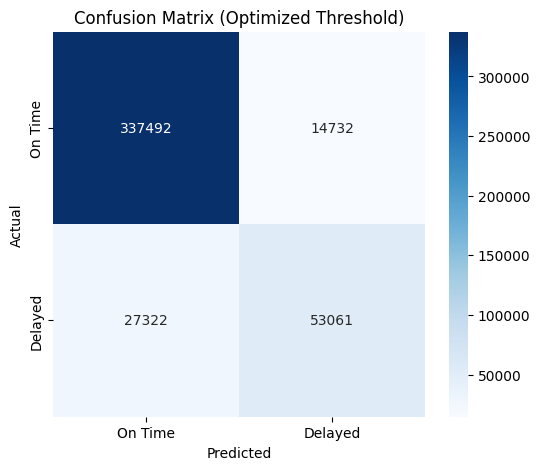

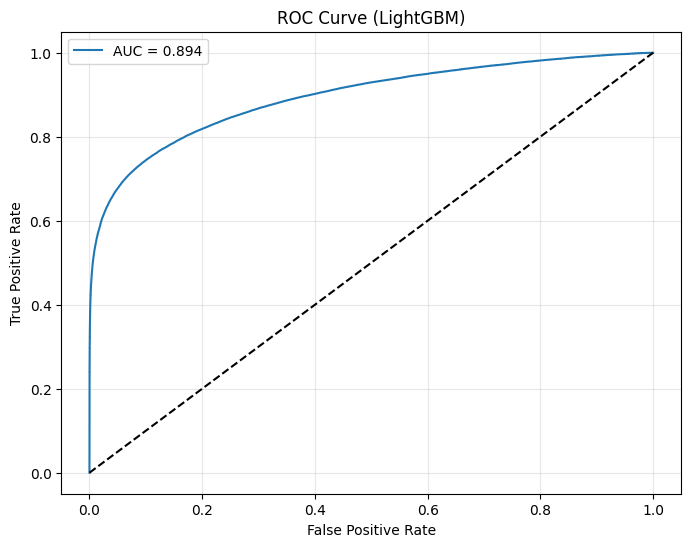

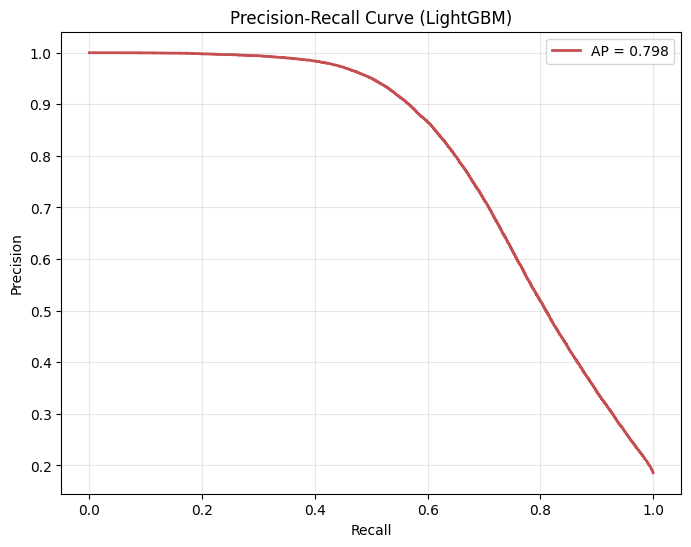

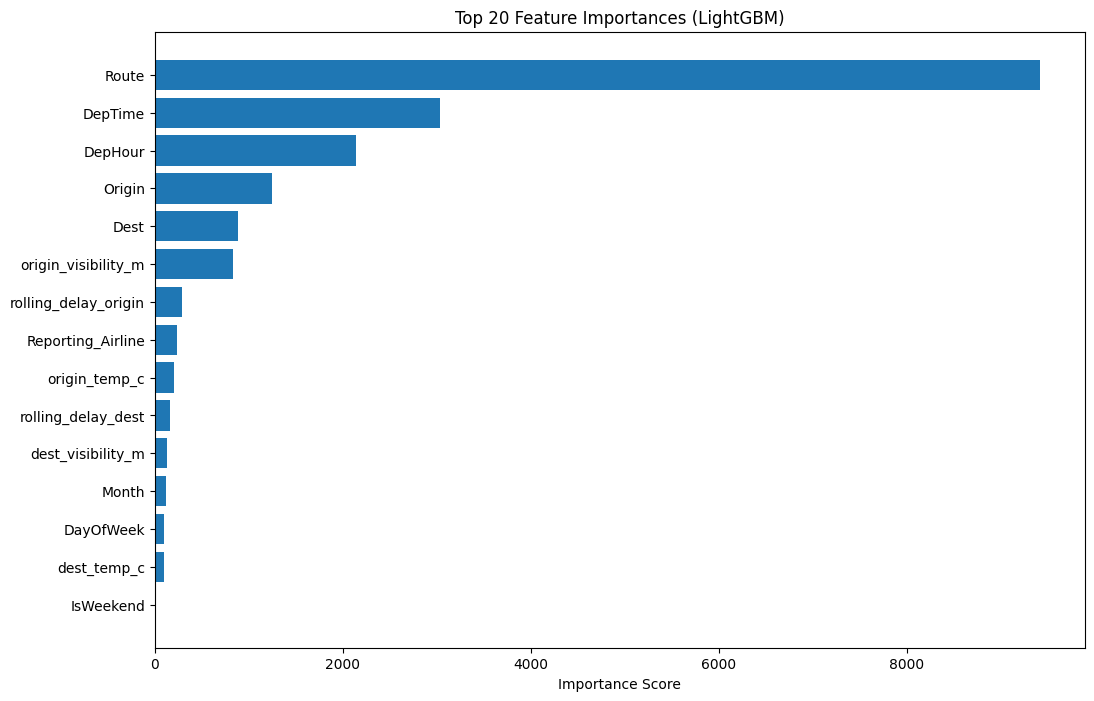

In [61]:
# ==========================================================
# FULL END-TO-END PIPELINE (ONE SINGLE BLOCK)
# LightGBM + Rolling Delay Features + Threshold Optimization
# ==========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# 1. CLEANING + REMOVE LEAKING COLUMNS
# ==========================================================
leak_cols = ["ArrDelay", "ArrDel30"]
for col in leak_cols:
    if col in df.columns:
        df = df.drop(columns=col)

if "CRSDepTime" in df.columns:
    df = df.drop(columns=["CRSDepTime"])
# ============================================================
# 2. CREATE ROLLING DELAY FEATURES (NO FlightDate NEEDED)
# ============================================================

import pandas as pd

df = df.copy()

# STEP 1 — Create a pseudo-date for ordering (required for rolling window)
# We will treat DayOfWeek and DepHour as ordering features
df["PseudoDate"] = (
      df["Year"].astype(str) + "-" +
      df["Month"].astype(str) + "-" +
      df["DayOfWeek"].astype(str) + "-" +
      df["DepHour"].astype(str)
)

# convert to a sortable timestamp (not real date, but consistent)
df["PseudoDate"] = pd.to_datetime(df["PseudoDate"], format="%Y-%m-%d-%H", errors="coerce")

# STEP 2 — Sort dataset for correct temporal order
df = df.sort_values(["Origin", "PseudoDate"]).reset_index(drop=True)

# STEP 3 — Rolling delay for each ORIGIN airport
df["rolling_delay_origin"] = (
    df.groupby("Origin")["ArrDel15"]
      .transform(lambda x: x.rolling(window=200, min_periods=20).mean())
)

# STEP 4 — Rolling delay for each DEST airport
df["rolling_delay_dest"] = (
    df.groupby("Dest")["ArrDel15"]
      .transform(lambda x: x.rolling(window=200, min_periods=20).mean())
)

# STEP 5 — Fill NaN at top of window for first flights
df["rolling_delay_origin"] = df["rolling_delay_origin"].fillna(df["rolling_delay_origin"].mean())
df["rolling_delay_dest"]   = df["rolling_delay_dest"].fillna(df["rolling_delay_dest"].mean())

print("✔ Rolling delay features created successfully.")


# ==========================================================
# 3. FEATURE SELECTION
# ==========================================================
target = "ArrDel15"

feature_cols = [
    "DepTime",
    "Origin", "Dest", "Route",
    "Month", "DayOfWeek",
    "Reporting_Airline",
    "origin_temp_c", "dest_temp_c",
    "origin_visibility_m", "dest_visibility_m",
    "IsWeekend", "IsHoliday",
    "DepHour",
    "rolling_delay_origin",
    "rolling_delay_dest",
    "rolling_delay_route"
]

feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols]
y = df[target]

# ==========================================================
# 4. ENCODING CATEGORICALS
# ==========================================================
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols:
    X[col] = X[col].astype("category")

# ==========================================================
# 5. TRAIN/TEST SPLIT
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================================
# 6. LIGHTGBM TRAINING
# ==========================================================
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
test_data  = lgb.Dataset(X_test,  label=y_test,  categorical_feature=cat_cols)

params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5
}

model = lgb.train(params, train_data, num_boost_round=300)

# ==========================================================
# 7. PREDICT WITH DEFAULT 0.5 THRESHOLD
# ==========================================================
pred_prob = model.predict(X_test)
pred_default = (pred_prob > 0.5).astype(int)

print("\nDEFAULT THRESHOLD (0.5)")
print("Accuracy:", accuracy_score(y_test, pred_default))
print("Precision:", precision_score(y_test, pred_default))
print("Recall:", recall_score(y_test, pred_default))
print("F1:", f1_score(y_test, pred_default))
print("ROC-AUC:", roc_auc_score(y_test, pred_prob))

# ==========================================================
# 8. FIND BEST THRESHOLD (MAX F1)
# ==========================================================
best_t = 0
best_f1 = 0

for t in np.arange(0.05, 0.95, 0.05):
    pred_temp = (pred_prob > t).astype(int)
    f1 = f1_score(y_test, pred_temp)
    print(f"t={t:.2f} | F1={f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("\nBEST THRESHOLD:", best_t, "| F1:", best_f1)

# ==========================================================
# 9. EVALUATE WITH OPTIMAL THRESHOLD
# ==========================================================
pred_opt = (pred_prob > best_t).astype(int)

print("\nMETRICS WITH OPTIMAL THRESHOLD")
print("Accuracy:", accuracy_score(y_test, pred_opt))
print("Precision:", precision_score(y_test, pred_opt))
print("Recall:", recall_score(y_test, pred_opt))
print("F1:", f1_score(y_test, pred_opt))
print("ROC-AUC:", roc_auc_score(y_test, pred_prob))

# ==========================================================
# 10. CONFUSION MATRIX
# ==========================================================
cm = confusion_matrix(y_test, pred_opt)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["On Time","Delayed"],
            yticklabels=["On Time","Delayed"])
plt.title("Confusion Matrix (Optimized Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================================================
# 11. ROC CURVE
# ==========================================================
fpr, tpr, _ = roc_curve(y_test, pred_prob)
auc_score = roc_auc_score(y_test, pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LightGBM)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ==========================================================
# 12. PRECISION–RECALL CURVE
# ==========================================================
precision, recall, _ = precision_recall_curve(y_test, pred_prob)
ap = average_precision_score(y_test, pred_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, lw=2, color="#C44E52", label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightGBM)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ==========================================================
# 13. FEATURE IMPORTANCE BAR CHART
# ==========================================================
importance = model.feature_importance()
names = X.columns
idx = np.argsort(importance)[::-1]

plt.figure(figsize=(12,8))
plt.barh(names[idx[:20]], importance[idx[:20]])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (LightGBM)")
plt.xlabel("Importance Score")
plt.show()
